# Worksheet 6 - Problem 9
## Digit Recognition Using Gaussian Generative Model
In this workbook, handwritten digits from the MNIST database are classified using Gaussian Naive Bayes.  Additional information on the MNIST data can be found at http://yann.lecun.com/exdb/mnist/.

The notebook includes the following sections:
- Obtain Data and Load Data
- Create Gaussian Naive Bayes Classifier from Training Data
- Tune c Parameter Using Validation Data
- Evaluate Classifer Performance on Test Data
- Plot Misclassified Digits
- Conclusions

In [1]:
# import packages
import random
import itertools
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [2]:
# set random seed
random.seed(6785)

In [3]:
%matplotlib inline

## Obtain and Load Data
In this section, we download and unzip the MNIST dataset, read it into Python, split the data into train, validation, and test subsets, and perform some simple checks to verify that the data was loaded properly.


In [4]:
# make sure we are in the correct directory
%cd /Users/joshwilson/Documents/DSE/jsw037/DSE210/

/Users/joshwilson/Documents/DSE/jsw037/DSE210


In [5]:
# create and move to 'data' directory (first delete the folder if it already exists)
!rm -rf 'ws6data'
!mkdir 'ws6data'
%cd ws6data

/Users/joshwilson/Documents/DSE/jsw037/DSE210/ws6data


In [6]:
# get the training set image data
!curl http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -o 'train-images.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0   550k      0  0:00:17  0:00:17 --:--:--  386k


In [7]:
# get the training set label data
!curl http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -o 'train-labels.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  97891      0 --:--:-- --:--:-- --:--:-- 98234


In [8]:
# get the test set image data
!curl http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -o 'test-images.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0   417k      0  0:00:03  0:00:03 --:--:--  417k


In [9]:
# get the test set label data
!curl http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -o 'test-labels.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  21880      0 --:--:-- --:--:-- --:--:-- 22156


In [10]:
# check that files have downloaded
!ls

test-images.gz  test-labels.gz  train-images.gz train-labels.gz


In [11]:
# uncompress the data
!gunzip test-images.gz test-labels.gz train-images.gz train-labels.gz

In [12]:
# check that *.gz files have been replaced by appropriate directories
!ls

test-images  test-labels  train-images train-labels


In [13]:
# download loader.py file
!curl http://cseweb.ucsd.edu/~dasgupta/dse210/loader.py -o 'loader.py'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1236  100  1236    0     0  19247      0 --:--:-- --:--:-- --:--:-- 19935


In [14]:
# %load loader.py
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()


In [15]:
# load training data
orig_train_images, orig_train_labels = loadmnist('train-images', 'train-labels')

In [16]:
# load test data
test_images, test_labels = loadmnist('test-images', 'test-labels')

In [17]:
# check shape of data
print 'orig_train_images shape:', orig_train_images.shape
print 'orig_train_labels shape:', orig_train_labels.shape
print 'test_images shape:', test_images.shape
print 'test_labels shape:', test_labels.shape

orig_train_images shape: (60000, 784)
orig_train_labels shape: (60000,)
test_images shape: (10000, 784)
test_labels shape: (10000,)


In [18]:
# split training data into 80% training and 20% validation data
train_size = 50000
indices = np.random.permutation(60000)
train_idx, val_idx = indices[:train_size], indices[train_size:]
train_images, val_images = orig_train_images[train_idx,:], orig_train_images[val_idx,:]
train_labels, val_labels = orig_train_labels[train_idx], orig_train_labels[val_idx]

In [19]:
# check shape of resulting training and validation data
print 'train_images shape:', train_images.shape
print 'train_labels shape:', train_labels.shape
print 'val_images shape:', val_images.shape
print 'val_labels shape:', val_labels.shape

train_images shape: (50000, 784)
train_labels shape: (50000,)
val_images shape: (10000, 784)
val_labels shape: (10000,)


train_images[47015] label: 0


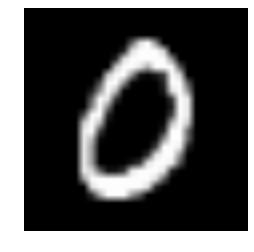

val_images[2188] label: 5


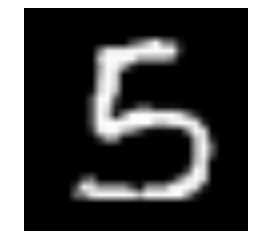

test_images[3421] label: 1


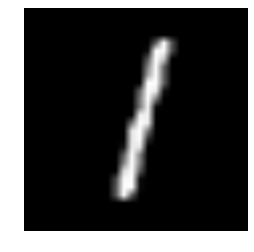

In [20]:
# display some random images and their labels
num_images = 1
for i in np.random.randint(0,train_images.shape[0],num_images):
    print 'train_images[%s] label: %s' % (i, train_labels[i])
    displaychar(train_images[i])

for i in np.random.randint(0,val_images.shape[0],num_images):
    print 'val_images[%s] label: %s' % (i, val_labels[i])
    displaychar(val_images[i])
    
for i in np.random.randint(0,test_images.shape[0],num_images):
    print 'test_images[%s] label: %s' % (i, test_labels[i])
    displaychar(test_images[i])

## Create Gaussian Naive Bayes Classifier from Training Data
Here, we create a Gaussian Naive Bayes classifier using the MNIST training data, by performing the following steps:

1.  Calculate prior probabilities for each class (i.e. each digit, 0-9)
2.  Calculate the mean vector and covariance matrix for each class
3.  Generate multivariate Gaussian distributions for each class
4.  Make predictions on the training data by assigning each data point to the class with the highest log likelihoods
5.  Check accuracy of predictions on training data


In [21]:
# calculate prior probabilities
classes, counts = np.unique(train_labels, return_counts=True)

# calculate fraction of each count
class_priors = 1.0 * counts / sum(counts)

print 'class values:\n', classes
print '\nclass priors:\n', class_priors
print '\nCheck that sum of all class prior probabilities add to one:\n', sum(class_priors)

class values:
[0 1 2 3 4 5 6 7 8 9]

class priors:
[ 0.09878  0.11298  0.09894  0.10134  0.0971   0.09032  0.09924  0.1051
  0.09742  0.09878]

Check that sum of all class prior probabilities add to one:
1.0


In [22]:
# calculate class means, covariance matrices, and posterior probabilities
class_means = []
class_covs = []
class_covs_unreg = []
class_dist = []

# set initial c value, which will be used to regularize covariance matrices
c_init = 5.0

for k in classes:
    # get images for class k
    class_idx = np.where(train_labels == k)[0]
    class_images = train_images[class_idx]
    
    # calculate class mean and covariance matrix
    class_mean = np.apply_along_axis(np.average, 0, class_images)
    class_cov_unregularized = np.cov(class_images.T)
    
    # adjust covariance matrix by adding small value to diagonal of unregularized covariance matrix
    class_cov = class_cov_unregularized + np.eye(class_cov_unregularized.shape[0])*c_init

    # append class means and covariance matrices 
    class_means.append(class_mean)
    class_covs.append(class_cov)
    class_covs_unreg.append(class_cov_unregularized)

    # calculate gaussians
    p_k = multivariate_normal(mean = class_mean, cov = class_cov)
    class_dist.append(p_k)


In [23]:
# make predictions on training data
probs = []
for k in classes:
    class_probs = []
    for img in train_images:
        p_k = np.log(class_priors[k]) + class_dist[k].logpdf(img)
        class_probs.append(p_k)
    probs.append(class_probs)
probs = np.array(probs).T
train_pred = [np.where(row == np.max(row))[0][0] for row in probs]

In [24]:
# check accuracy of predictions on training data
print("Number of mislabeled points out of a total %d points : %d" 
      % (train_images.shape[0], (train_labels != train_pred).sum()))

print("Train data error rate (c parameter = %.2f) : %.4f"
      % (c_init, float((train_labels != train_pred).sum()) / float(train_images.shape[0])))

Number of mislabeled points out of a total 50000 points : 5104
Train data error rate (c parameter = 5.00) : 0.1021


## Modify c Parameter Using Validation Data
In this section, we vary the c parameter from its initial randomly chosen value to determine a value that produces a low error rate on the validation data.  We begin with the initally chosen c value and determine the corresponding error.  Then we iteratively update the c parameter as follows;

1.  Create a small pool of new c values to test
2.  Build a new prediction model and check the accuracy resulting from each new c value
3.  Update c if the error rate improves

In [25]:
# get initial accuracy on validation data

# make predictions on validation data using original c value
probs = []
for k in classes:
    class_probs = []
    for img in val_images:
        p_k = np.log(class_priors[k]) + class_dist[k].logpdf(img)
        class_probs.append(p_k)
    probs.append(class_probs)
probs = np.array(probs).T
val_pred = [np.where(row == np.max(row))[0][0] for row in probs]

# check accuracy of predictions on validation data
print("Number of mislabeled points out of a total %d points : %d" 
      % (val_images.shape[0], (val_labels != val_pred).sum()))

init_error = float((val_labels != val_pred).sum()) / float(val_images.shape[0])

print "Validation data error rate (c parameter = %.2f) : %.4f" % (c_init, init_error)

Number of mislabeled points out of a total 10000 points : 1365
Validation data error rate (c parameter = 5.00) : 0.1365


In [26]:
# parameters to use in our loop to find a good c value
steps = 15
min_c = 1.0
max_c = 1.0e+4
best_c = c_init
min_err = init_error

# iteratively update c value
print 'error on validation data for varying c values:\n'
for i in range(steps):
    print 'step %d:  c = %f, error = %f' % (i, best_c, min_err)
    c_vals = [0.05*best_c, 0.99*best_c, 1.01*best_c, 20.0*best_c, random.randint(min_c,max_c)]
    
    # make predictions on validation data for each value of c
    c_preds = []
    c_err = []

    for c in c_vals:
        # check if c is within acceptable range of values
        if c < min_c or c > max_c:
            c_err.append(1.0)
            continue

        # make predictions using current c value
        probs = []
        for k in classes:
            class_mean = class_means[k]
            class_cov = class_covs_unreg[k] + np.eye(class_covs_unreg[k].shape[0])*c
            mn_k = multivariate_normal(mean = class_mean, cov = class_cov, allow_singular = True)
            class_probs = []
            for img in val_images:
                p_k = np.log(class_priors[k]) + mn_k.logpdf(img)
                class_probs.append(p_k)
            probs.append(class_probs)
        probs = np.array(probs).T
        preds = [np.where(row == np.max(row))[0][0] for row in probs]
        
        # determine accuracy
        err = float((val_labels != preds).sum()) / float(len(val_labels)) 
        c_err.append(err)
        
    # identify min error and corresponding c value
    cur_err = np.min(c_err)
    cur_c = c_vals[np.argmin(c_err)]
    
    # update best_c and min_err
    if cur_err < min_err:
        best_c = cur_c
        min_err = cur_err

print '\nfinal result:  c = %f, error = %f' % (best_c, min_err)


error on validation data for varying c values:

step 0:  c = 5.000000, error = 0.136500
step 1:  c = 5219.000000, error = 0.047700
step 2:  c = 4195.000000, error = 0.046100
step 3:  c = 4153.050000, error = 0.045900
step 4:  c = 4153.050000, error = 0.045900
step 5:  c = 3797.000000, error = 0.045100
step 6:  c = 3759.030000, error = 0.044900
step 7:  c = 3721.439700, error = 0.044800
step 8:  c = 3721.439700, error = 0.044800
step 9:  c = 3584.000000, error = 0.044700
step 10:  c = 3619.840000, error = 0.044600
step 11:  c = 3619.840000, error = 0.044600
step 12:  c = 3619.840000, error = 0.044600
step 13:  c = 3619.840000, error = 0.044600
step 14:  c = 3619.840000, error = 0.044600

final result:  c = 3619.840000, error = 0.044600


## Evaluate Performance on Test Data
In this section we evaluate the test error rate of the model obtained by tuning the c parameter using the validation data.

In [27]:
# make predictions
probs = []
for k in classes:
    class_mean = class_means[k]
    class_cov = class_covs_unreg[k] + np.eye(class_covs[k].shape[0])*best_c
    mn_k = multivariate_normal(mean = class_mean, cov = class_cov, allow_singular = True)
    class_probs = []
    for img in test_images:
        p_k = np.log(class_priors[k]) + mn_k.logpdf(img)
        class_probs.append(p_k)
    probs.append(class_probs)
probs = np.array(probs).T
test_pred = [np.where(row == np.max(row))[0][0] for row in probs]

In [28]:
# check accuracy of predictions on test data
print("Number of mislabeled points out of a total %d points : %d" 
      % (test_images.shape[0], (test_labels != test_pred).sum()))

print("Test data error rate : %.4f"
      % (float((test_labels != test_pred).sum()) / float(test_images.shape[0])))

Number of mislabeled points out of a total 10000 points : 432
Test data error rate : 0.0432


In [29]:
# plot_confusion_matrix code from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

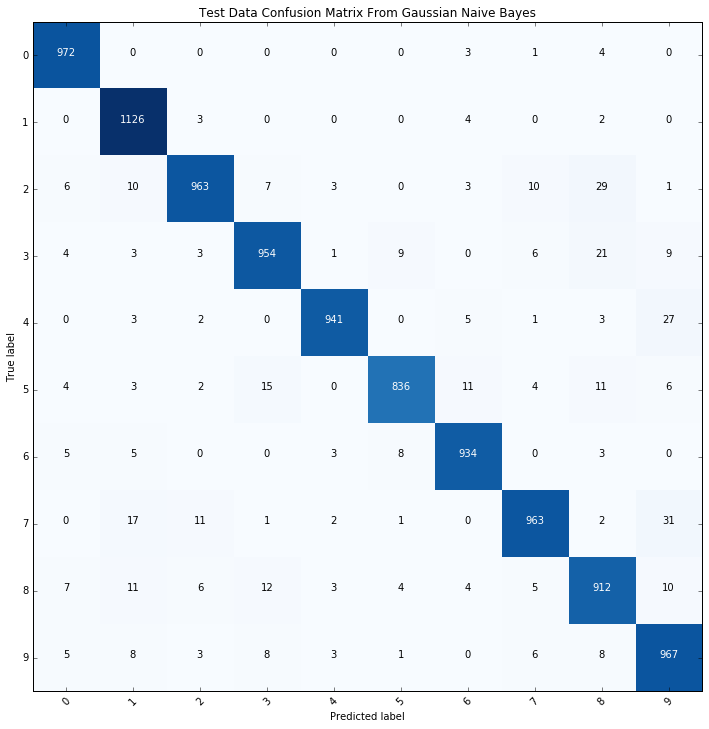

In [30]:
# visualize error via confusion matrix plot
cnf_matrix_test = confusion_matrix(test_labels, test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix_test, classes=np.unique(test_labels),
                      title='Test Data Confusion Matrix From Gaussian Naive Bayes')

plt.show();

## Plot Misclassified Digits
In this section, we will plot a few random misclassified digits from the test data, along with the log likelihood of the digit for each class.

5 random misclassified images from test data:

test_images[1549], label: 4, prediction: 6

class 0 posterior log likelihood = -4203.31836646
class 1 posterior log likelihood = -4249.12230204
class 2 posterior log likelihood = -4148.3989032
class 3 posterior log likelihood = -4176.79666308
class 4 posterior log likelihood = -4154.73005935
class 5 posterior log likelihood = -4188.04303447
class 6 posterior log likelihood = -4120.49131997
class 7 posterior log likelihood = -4240.98979358
class 8 posterior log likelihood = -4179.05975694
class 9 posterior log likelihood = -4243.2522547


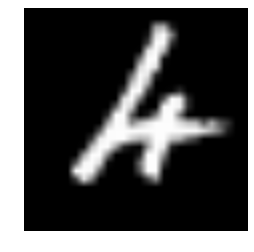

test_images[6598], label: 5, prediction: 6

class 0 posterior log likelihood = -4122.24033907
class 1 posterior log likelihood = -4225.69999656
class 2 posterior log likelihood = -4147.42113649
class 3 posterior log likelihood = -4127.20802016
class 4 posterior log likelihood = -4197.93198051
class 5 posterior log likelihood = -4122.17013769
class 6 posterior log likelihood = -4109.67437144
class 7 posterior log likelihood = -4197.88355361
class 8 posterior log likelihood = -4179.99516295
class 9 posterior log likelihood = -4185.31027802


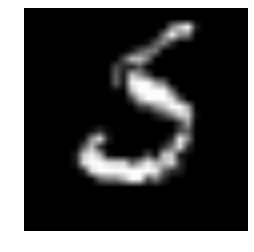

test_images[5973], label: 3, prediction: 8

class 0 posterior log likelihood = -4198.42506941
class 1 posterior log likelihood = -4398.80762806
class 2 posterior log likelihood = -4186.22576989
class 3 posterior log likelihood = -4150.02489883
class 4 posterior log likelihood = -4206.88405758
class 5 posterior log likelihood = -4142.58945658
class 6 posterior log likelihood = -4232.22928843
class 7 posterior log likelihood = -4239.96104882
class 8 posterior log likelihood = -4131.34605706
class 9 posterior log likelihood = -4170.5824965


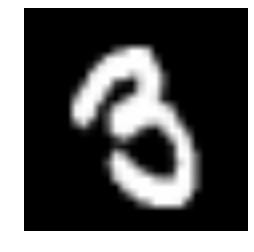

test_images[741], label: 2, prediction: 8

class 0 posterior log likelihood = -4164.06622797
class 1 posterior log likelihood = -4170.23922729
class 2 posterior log likelihood = -4112.42018226
class 3 posterior log likelihood = -4122.30048324
class 4 posterior log likelihood = -4172.95683276
class 5 posterior log likelihood = -4178.37028405
class 6 posterior log likelihood = -4235.86494675
class 7 posterior log likelihood = -4144.00187856
class 8 posterior log likelihood = -4098.75131895
class 9 posterior log likelihood = -4150.9048959


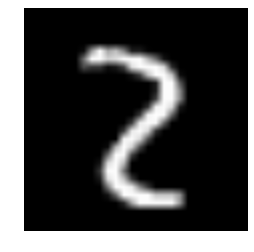

test_images[2044], label: 2, prediction: 7

class 0 posterior log likelihood = -4243.03806209
class 1 posterior log likelihood = -4479.95854127
class 2 posterior log likelihood = -4216.69912704
class 3 posterior log likelihood = -4237.31688919
class 4 posterior log likelihood = -4266.75951108
class 5 posterior log likelihood = -4270.8248882
class 6 posterior log likelihood = -4438.99846701
class 7 posterior log likelihood = -4177.84321407
class 8 posterior log likelihood = -4190.64563394
class 9 posterior log likelihood = -4223.46004045


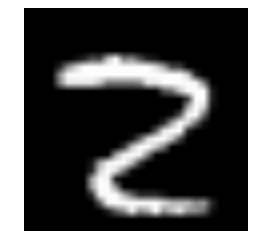

In [31]:
# find and visualize a few random missclassified images
misclassified_idx = np.where(test_labels != test_pred)[0]

num_images = 5

print num_images, 'random misclassified images from test data:\n'

for i in np.random.choice(misclassified_idx, size = num_images, replace = False):
    img_i = test_images[i]
    print 'test_images[%s], label: %s, prediction: %s\n' % (i, test_labels[i], test_pred[i])
    
    posterior_probs = []
    for k in classes:
        class_mean = class_means[k]
        class_cov = class_covs_unreg[k] + np.eye(class_covs[k].shape[0])*best_c
        mn_k = multivariate_normal(mean = class_mean, cov = class_cov, allow_singular = True)
        post_prob_k = np.log(class_priors[k]) + mn_k.logpdf(img_i)
        print 'class', k, 'posterior log likelihood =', post_prob_k
    displaychar(img_i)    
    

## Conclusions
The initial choice of c resulted in a training error rate of about 10%, and a validation error rate of about 13.5%.  Tuning the c parameter on the validation data improved model performance, reducing validation error to below 5% and resulting in a test error rate of about 4.3% in the final model.